# Imports

In [1]:
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import faiss

## Data Preprocessing

In [22]:
# read & merge data
movies = pd.read_csv('Data/movies.csv')
ratings = pd.read_csv('Data/ratings.csv')
df = pd.merge(ratings, movies, on='movieId')
df.sort_values(by=['userId', 'timestamp'], inplace=True)

In [23]:
# assign unique index for each user & movie & rating and map dataframe columns to it
userid2id = {val:idx for idx, val in enumerate(sorted(df.userId.unique()))}
movieId2id = {val:idx for idx, val in enumerate(sorted(df.movieId.unique()))}
rating2id = {val:idx for idx, val in enumerate(sorted(df.rating.unique()))}

df['userId'] = df.userId.apply(lambda x: userid2id[x])
df['movieId'] = df.movieId.apply(lambda x: movieId2id[x])
df['rating_classes'] = df.rating.apply(lambda x: rating2id[x])

print(f'Total Numbers of Users: {df.userId.unique().shape[0]}')
print(f'Total Number of Movies: {df.movieId.unique().shape[0]}')
print(f'Unique Ratings: {df.rating.unique().shape[0]}')

Total Numbers of Users: 668
Total Number of Movies: 10325
Unique Ratings: 10


In [24]:
df.head()

,userId,movieId,rating,timestamp,title,genres,rating_classes
11486,0,2712,4.5,1217895728,Animal House (1978),Comedy,8
9898,0,1916,2.5,1217895736,Cocoon (1985),Comedy|Sci-Fi,4
11174,0,2357,3.5,1217895742,Goldfinger (1964),Action|Adventure|Thriller,6
1912,0,231,1.5,1217895750,Little Women (1994),Drama,2
9960,0,1962,2.0,1217895762,"Fly, The (1986)",Drama|Horror|Sci-Fi|Thriller,3


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105339 entries, 11486 to 105006
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userId          105339 non-null  int64  
 1   movieId         105339 non-null  int64  
 2   rating          105339 non-null  float64
 3   timestamp       105339 non-null  int64  
 4   title           105339 non-null  object 
 5   genres          105339 non-null  object 
 6   rating_classes  105339 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 6.4+ MB


In [26]:
df.rating.value_counts()

4.0    28880
3.0    21729
5.0    14856
3.5    12237
4.5     8187
2.0     7943
2.5     5484
1.0     3258
1.5     1567
0.5     1198
Name: rating, dtype: int64

* There is no null-values in dataset
* Number of movies rated 0 & 1 & 2 are relatively low

#### Feature Engineering

In [27]:
# extract information from time column
df.loc[:, 'timestamp'] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x))

df['quarter'] = df.timestamp.dt.quarter
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.weekday
df['hour'] = df.timestamp.dt.hour
df['weekend'] = df.timestamp.apply(lambda x: 1 if x.dayofweek > 5 else 0)

# construct part_of_day columns with values [Morning, Afternoon, Evening, Night]
def get_part_of_day(datetime_obj):
    time_of_day = pd.to_datetime(datetime_obj).strftime('%H:%M:%S')
    part_of_day = ''
    
    if '06:00:00' <= time_of_day < '12:00:00':
        part_of_day = 'Morning'
    elif '12:00:00' <= time_of_day < '18:00:00':
        part_of_day = 'Afternoon'
    elif '18:00:00' <= time_of_day < '22:00:00':
        part_of_day = 'Evening'
    else:
        part_of_day = 'Night'
    
    return part_of_day

df['part_of_day'] = df.timestamp.apply(lambda x: get_part_of_day(x))

# create decade dummy columns
def extract_decade(datetime_obj):
    year = datetime_obj.year
    start_year = (year // 10) * 10
    end_year = start_year + 9
    decade = f'{start_year}-{end_year}'
    return decade

df['release_decade'] = df.timestamp.apply(lambda x: extract_decade(x))

# create movie_age columns which shows time after it's release
mx = df.timestamp.max()
df['movie_age'] = df.timestamp.apply(lambda x: (mx - x).days / 360)
### add square root of movie_age
df['movie_age_sqrt'] = np.sqrt(df['movie_age'])

# create time variable which ordinally shows watched movies timeline
df['time'] = np.nan
for i in range(df.userId.unique().size):
    df.loc[df.userId==i, 'time'] = np.arange(1, df.loc[df.userId==i, 'time'].size+1, dtype=int)
### add square root & square of time
df['time_sqrt'] = np.square(df['time'])
df['time_square'] = np.sqrt(df['time'])

In [28]:
# each film could be in several genre, so simple pd.get_dummies do not work here
# instead, let's use following approach:
# each dummy column shows whether movie belongs this genre or not (so one film could be in several genres)
genres = []

for idx, val in df[['genres']].itertuples():
    l = val.split('|')
    for genre in l:
        if genre not in genres:
            genres.append(genre)

for genre in genres:
    df[genre] = 0
    for idx, val in df[[genre]].itertuples():
        if genre in df.iloc[idx,5]:
            df.iloc[idx,-1] = 1

In [29]:
### convert time categorical columns to dummy columns
dummy_cols = ['quarter', 'month', 'day', 'part_of_day', 'weekend', 'release_decade']
df = pd.concat([df, pd.get_dummies(df[dummy_cols], columns=dummy_cols, drop_first=True)], axis=1)

In [30]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres',
       'rating_classes', 'quarter', 'month', 'day', 'hour', 'weekend',
       'part_of_day', 'release_decade', 'movie_age', 'movie_age_sqrt', 'time',
       'time_sqrt', 'time_square', 'Comedy', 'Sci-Fi', 'Action', 'Adventure',
       'Thriller', 'Drama', 'Horror', 'Crime', 'War', 'Children', 'Fantasy',
       'Animation', 'Romance', 'IMAX', 'Mystery', 'Western', 'Film-Noir',
       'Documentary', 'Musical', '(no genres listed)', 'quarter_2',
       'quarter_3', 'quarter_4', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'part_of_day_Evening', 'part_of_day_Morning', 'part_of_day_Night',
       'weekend_1', 'release_decade_2000-2009', 'release_decade_2010-2019'],
      dtype='object')

## Matrix Factorization

In [31]:
features1 = ['movie_age', 'movie_age_sqrt', 'time', 'time_sqrt',
            'time_square', 'Comedy', 'Sci-Fi', 'Action', 'Adventure', 'Thriller',
            'Drama', 'Horror', 'Crime', 'War', 'Children', 'Fantasy', 'Animation',
            'Romance', 'IMAX', 'Mystery', 'Western', 'Film-Noir', 'Documentary',
            'Musical', '(no genres listed)', 'quarter_2', 'quarter_3', 'quarter_4',
            'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
            'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_1',
            'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'part_of_day_Evening',
            'part_of_day_Morning', 'part_of_day_Night', 'weekend_1',
            'release_decade_2000-2009', 'release_decade_2010-2019']

train_df, val_df = train_test_split(df, test_size=0.1, random_state=4444)
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=4444)

train_x, train_idxs, train_y = train_df[features1].values, train_df[['movieId', 'userId']].values, train_df['rating'].values
val_x, val_idxs, val_y = val_df[features1].values, val_df[['movieId', 'userId']].values, val_df['rating'].values
test_x, test_idxs, test_y = test_df[features1].values, test_df[['movieId', 'userId']].values, test_df['rating'].values

train_x, train_idxs, train_y = torch.Tensor(train_x), torch.Tensor(train_idxs).long(), torch.Tensor(train_y)
val_x, val_idxs, val_y = torch.Tensor(val_x), torch.Tensor(val_idxs).long(), torch.Tensor(val_y)
test_x, test_idxs, test_y = torch.Tensor(test_x), torch.Tensor(test_idxs,).long(), torch.Tensor(test_y)

# lets also normilize data based on training statistics
means = train_x.mean(axis=0)
stds = train_x.std(axis=0)

train_x = torch.divide(torch.subtract(train_x, means), stds)
val_x = torch.divide(torch.subtract(val_x, means), stds)
test_x = torch.divide(torch.subtract(test_x, means), stds)

In [32]:
class MatrixFactorizationDataset(Dataset):
    def __init__(self, x, indexes, y):
        self.x = x
        self.indexes = indexes
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return (self.x[idx],
                self.indexes[idx],
                self.y[idx])

In [33]:
class MatrixFactorizationMachine(nn.Module):
    def __init__(self, n_users, n_movies, embd_dim, features_dim, dropout=0.4):
        super().__init__()
        # initialize user & movie embeddings
        self.user_embd = nn.Embedding(n_users, embd_dim)
        self.movie_embd = nn.Embedding(n_movies, embd_dim)
        # initialize linear layer
        self.ln = nn.Linear(features_dim + 2 * embd_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, idxs):
        # get movie & user embeddings
        movie_emb = self.movie_embd(idxs[:,0])
        user_emb = self.user_embd(idxs[:,1])
        # pass it to linear layer
        out = torch.cat([user_emb, movie_emb, x], dim=1)
        out = self.dropout(out)
        out = self.ln(out)
        return out

In [34]:
n_epoch = 30
n_embd = 32
batch_size=4096

In [35]:
train_dataset = MatrixFactorizationDataset(train_x, train_idxs, train_y)
val_dataset = MatrixFactorizationDataset(val_x, val_idxs, val_y)
test_dataset = MatrixFactorizationDataset(test_x, test_idxs, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for n, (a,b,c) in enumerate(val_loader):
    print(a.shape, b.shape, c.shape)
    break

torch.Size([4096, 51]) torch.Size([4096, 2]) torch.Size([4096])


In [37]:
model = MatrixFactorizationMachine( n_users=df.userId.unique().shape[0], 
                                    n_movies=df.movieId.unique().shape[0], 
                                    embd_dim=n_embd,
                                    features_dim=a.shape[1])
model

RecommenderSystem(
  (user_embd): Embedding(668, 32)
  (movie_embd): Embedding(10325, 32)
  (ln): Linear(in_features=141, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [37]:
summary(model, input=(a,b,c))

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         21,376
├─Embedding: 1-2                         330,400
├─Linear: 1-3                            113
├─Dropout: 1-4                           --
Total params: 351,889
Trainable params: 351,889
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         21,376
├─Embedding: 1-2                         330,400
├─Linear: 1-3                            113
├─Dropout: 1-4                           --
Total params: 351,889
Trainable params: 351,889
Non-trainable params: 0

In [38]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=False)

In [39]:
## training loop
train_epoch_logs, val_epoch_logs = [], []
for epoch in range(n_epoch):
    train_epoch_loss = val_epoch_loss = 0
    model.train()
    for n_batch, (x, idxs, y) in enumerate(train_loader):
        y_hat = model(x, idxs)
        loss = loss_fn(y_hat.squeeze(axis=1), y)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for n_batch, (x, idxs, y) in enumerate(val_loader):
            y_hat = model(x, idxs)
            loss = loss_fn(y_hat.squeeze(axis=1), y)

            val_epoch_loss += loss.item()
    
    train_epoch_logs.append(train_epoch_loss/len(train_loader)) 
    val_epoch_logs.append(val_epoch_loss/len(val_loader))
    scheduler.step(train_epoch_loss/len(train_loader))
    if epoch % 5 == 0:
        print(f'Epoch: {epoch+1} | Train Loss: {train_epoch_loss/len(train_loader):.4} | Val Loss: {val_epoch_loss/(len(val_loader)):.4}')

Epoch: 1 | Train Loss: 10.58 | Val Loss: 5.261
Epoch: 6 | Train Loss: 1.458 | Val Loss: 0.8596
Epoch: 11 | Train Loss: 1.098 | Val Loss: 0.7833
Epoch: 16 | Train Loss: 0.958 | Val Loss: 0.7815
Epoch: 21 | Train Loss: 0.8849 | Val Loss: 0.7693
Epoch: 26 | Train Loss: 0.833 | Val Loss: 0.774


## Candidate Generator

### Feature Engineering

In [38]:
# add last 50 watched movies' indexes to each observation (index 10325 is padding idx)
ls = {}
for i in tqdm(range(df.userId.unique().shape[0])): 
    new_df = df[df.userId==i][['userId','movieId', 'rating', 'time']]
    new_df.reset_index(inplace=True)
    for j in range(new_df.shape[0]):
        features = new_df.iloc[j, :]
        if features.name == 0:
            ls[features.name] = [10325]
        else:
            idx = features.name
            new_df.iloc[idx-1,1]
            ls[features['index']] = list(new_df.iloc[:idx,2])

for i in range(105339):
    try:
        ls[i]
    except:
        ls[i] = [10325]

def func(x):
    return x[-50:]

ls = {k:func(v) for k, v in ls.items()}

def padder(x):
    return x + (50 - len(x)) * [10325]

ls = {k:padder(v) for k, v in ls.items()}

df['watched_movies'] = df.index.map(lambda x: np.array(ls[x]))

100%|██████████| 668/668 [00:12<00:00, 53.60it/s]


In [39]:
dummy_cols = ['weekend', 'hour', 'quarter_2','quarter_3', 'quarter_4', 'month_2',
              'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
              'month_9', 'month_10', 'month_11', 'month_12', 'day_1', 'day_2',
              'day_3', 'day_4', 'day_5', 'day_6', 'part_of_day_Evening',
              'part_of_day_Morning', 'part_of_day_Night']

In [40]:
train_df = df[df.movieId>80]
val_df = df[df.userId<=40]
test_df = df[(df.userId>40)&(df.userId<=80)]

In [41]:
X_int_train = train_df['movieId'].values                                                 # indices of target movies
Xd_train = train_df[dummy_cols].values                                                   # user/time features
Xw_train = np.array([np.array(i,dtype=int) for i in train_df['watched_movies'].values])  # indices of last 50 movies watched

X_int_val = val_df[ 'movieId'].values
Xd_val = val_df[dummy_cols].values
Xw_val = np.array([np.array(i,dtype=int) for i in val_df['watched_movies'].values]) 

X_int_test = test_df[ 'movieId'].values
Xd_test = test_df[dummy_cols].values
Xw_test = np.array([np.array(i,dtype=int) for i in test_df['watched_movies'].values]) 

X_int_train, Xd_train = torch.Tensor(X_int_train).long(), torch.Tensor(Xd_train).float()
Xw_train = torch.Tensor(Xw_train).long()

X_int_val, Xd_val = torch.Tensor(X_int_val).long(), torch.Tensor(Xd_val).float()
Xw_val = torch.Tensor(Xw_val).long()

X_int_test, Xd_test = torch.Tensor(X_int_test).long(), torch.Tensor(Xd_test).float()
Xw_test = torch.Tensor(Xw_test).long()

In [42]:
class DatasetForCandidateGenerator(Dataset):
    def __init__(self, X_int, Xd, Xw):
        self.X_int = X_int
        self.Xd = Xd
        self.Xw = Xw
    
    def __len__(self):
        return self.X_int.shape[0]
    
    def __getitem__(self, idx):
        return self.X_int[idx], self.Xd[idx], self.Xw[idx]

train_dataset = DatasetForCandidateGenerator(X_int_train, Xd_train, Xw_train)
val_dataset = DatasetForCandidateGenerator(X_int_val, Xd_val, Xw_val)
test_dataset = DatasetForCandidateGenerator(X_int_test, Xd_test, Xw_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

a, b, c = next(iter(train_loader))
a.shape, b.shape, c.shape

(torch.Size([4096]), torch.Size([4096, 25]), torch.Size([4096, 50]))

In [43]:
class CandidatesGenerator(nn.Module):
    def __init__(self, 
                 n_movies,
                 movie_emb_dim,    
                 sparse_matrix_dim,
                 hidden_dim):
        super().__init__()
        # embedding for movies
        self.movie_embd = nn.Embedding(n_movies+1, movie_emb_dim, padding_idx=n_movies)

        # linear layers
        self.ln1 = nn.Linear(movie_emb_dim + sparse_matrix_dim, hidden_dim * 4)
        self.ln2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)

        # classifier layers
        self.classifier = nn.Linear(hidden_dim * 2, n_movies)

        # dropout
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, Xd, Xw):
        # get average vectors of watched movies
        watched_embedding = torch.mean(self.movie_embd(Xw.long()), axis=1)
        # concatenate watched movies' vector to user features 
        out = torch.cat([Xd, watched_embedding], axis=1)

        out = self.ln1(out)
        out = F.leaky_relu(out, negative_slope=0.2)
        out = self.dropout(out)

        out = self.ln2(out)
        logits = F.leaky_relu(out, negative_slope=0.2)
        logits = self.dropout(logits)

        logits = self.classifier(logits)
        return out, logits

In [45]:
model = CandidatesGenerator(n_movies=10325,
                            movie_emb_dim=32,    
                            sparse_matrix_dim=48,
                            hidden_dim=64)
model

CandidatesGenerator(
  (movie_embd): Embedding(10326, 32, padding_idx=10325)
  (ln1): Linear(in_features=80, out_features=256, bias=True)
  (ln2): Linear(in_features=256, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=10325, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [46]:
summary(model, input=(a,b,c))

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         330,432
├─Linear: 1-2                            20,736
├─Linear: 1-3                            32,896
├─Linear: 1-4                            1,331,925
├─Dropout: 1-5                           --
Total params: 1,715,989
Trainable params: 1,715,989
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         330,432
├─Linear: 1-2                            20,736
├─Linear: 1-3                            32,896
├─Linear: 1-4                            1,331,925
├─Dropout: 1-5                           --
Total params: 1,715,989
Trainable params: 1,715,989
Non-trainable params: 0

In [84]:
lr_rate = 0.0004
n_epoch = 110

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=False)

In [77]:
train_epoch_losses, val_epoch_losses = [], []

In [85]:
for epoch in range(n_epoch):
    train_epoch_loss, val_epoch_loss = 0, 0
    train_epoch_acc, val_epoch_acc = 0, 0
    
    model.train()
    for n_batch, (X_int, Xd, Xw) in enumerate(train_loader):
        y_hat, logits = model(Xd, Xw)
        loss = loss_fn(logits, X_int)
        
        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
        train_epoch_loss += loss.item()
        train_epoch_acc += (torch.argmax(F.softmax(logits, dim=1), axis=1) == X_int).sum().item() /  X_int.size()[0]
    
    model.eval()
    with torch.no_grad():
        for n_batch, (X_int, Xd, Xw) in enumerate(val_loader):
            y_hat, logits = model(Xd, Xw)
            loss = loss_fn(logits, X_int)
            val_epoch_loss += loss.item()
            val_epoch_acc += (torch.argmax(F.softmax(logits, dim=1), axis=1) == X_int).sum().item() /  X_int.size()[0]
    
    train_epoch_losses.append(train_epoch_loss/len(train_loader))
    val_epoch_losses.append(val_epoch_loss/len(val_loader))
    scheduler.step(train_epoch_loss/len(train_loader))
    if epoch % 5 == 0:
        print(f'Epoch: {epoch+1} | Train Loss: {train_epoch_loss/len(train_loader):.3} | Train Acc: {train_epoch_acc / len(train_loader):.3} \
| Val Loss: {val_epoch_loss/len(val_loader):.3} | Vall Acc: {val_epoch_acc / len(val_loader):.3}')

Epoch: 1 | Train Loss: 4.29 | Train Acc: 0.177 | Val Loss: 5.3 | Vall Acc: 0.204
Epoch: 6 | Train Loss: 4.27 | Train Acc: 0.18 | Val Loss: 5.3 | Vall Acc: 0.204


In [88]:
torch.save(model.state_dict(), 'weights/CGWeights1.pt')

## Vizualization

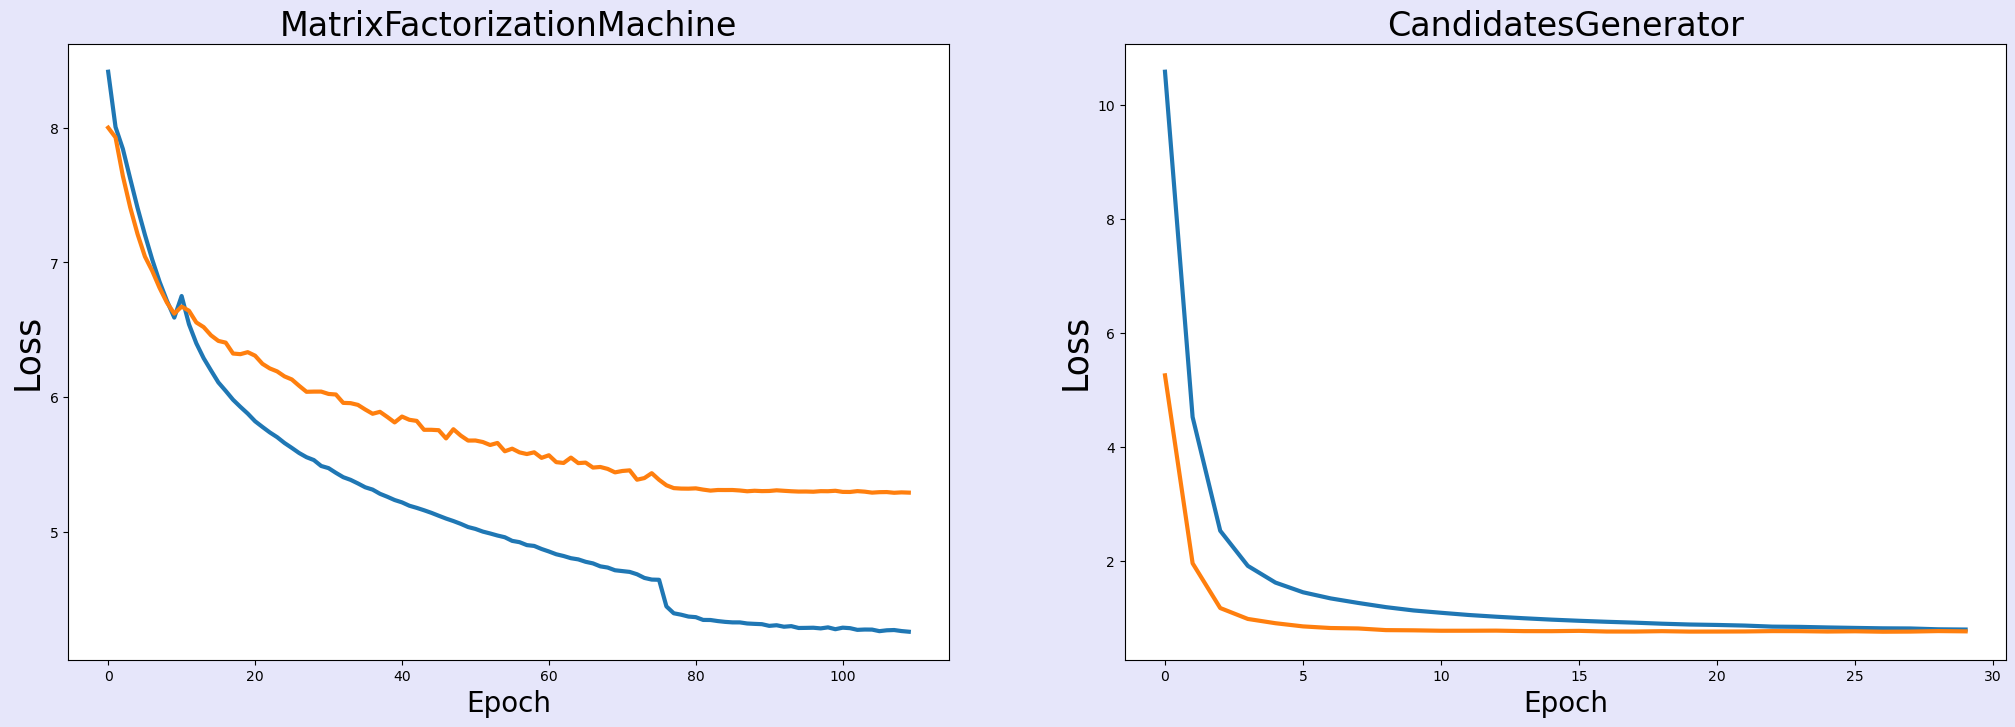

In [103]:
fig, ax = plt.subplots(1,2, figsize=(25, 8), facecolor='lavender')

ax[0].set_title("MatrixFactorizationMachine", size=24)
ax[0].plot([*range(len(train_epoch_losses))], train_epoch_losses, linewidth=3)
ax[0].plot([*range(len(val_epoch_losses))], val_epoch_losses, linewidth=3)
ax[0].set_ylabel('Loss', size=25)
ax[0].set_xlabel('Epoch', size=20)

ax[1].set_title("CandidatesGenerator", size=24)
ax[1].plot([*range(len(train_epoch_logs))], train_epoch_logs, linewidth=3)
ax[1].plot([*range(len(val_epoch_logs))], val_epoch_logs, linewidth=3)
ax[1].set_ylabel('Loss', size=25)
ax[1].set_xlabel('Epoch', size=20)
plt.savefig("charts/training.png", dpi=300);

In [104]:
train_embds = None
train_ints = None
model.eval()
with torch.no_grad():
    for n_batch, (X_int, Xd, Xw) in enumerate(train_loader):
        y_hat, _ = model(Xd, Xw)
        if train_embds == None:
            train_embds = y_hat
            train_ints = X_int
        else:
            train_embds = torch.cat([train_embds, y_hat], axis=0)
            train_ints = torch.cat([train_ints, X_int], axis=0)

val_embds = None
val_ints = None
model.eval()
with torch.no_grad():
    for n_batch, (X_int, Xd, Xw) in enumerate(val_loader):
        y_hat, _ = model(Xd, Xw)
        if val_embds == None:
            val_embds = y_hat
            val_ints = X_int
        else:
            val_embds = torch.cat([val_embds,y_hat], axis=0)
            val_ints = torch.cat([val_ints,X_int], axis=0)

test_embds = None
test_ints = None
model.eval()
with torch.no_grad():
    for n_batch, (X_int, Xd, Xw) in enumerate(test_loader):
        y_hat, _ = model(Xd, Xw)
        if test_embds == None:
            test_embds = y_hat
            test_ints = X_int
        else:
            test_embds = torch.cat([test_embds,y_hat], axis=0)
            test_ints = torch.cat([test_ints,X_int], axis=0)

In [105]:
train_embds.shape, val_embds.shape, test_embds.shape

(torch.Size([101947, 128]), torch.Size([3944, 128]), torch.Size([5388, 128]))

In [121]:
index = faiss.IndexFlatL2(128)
index.add(train_embds.detach().numpy())

val_scores, val_indices = index.search(val_embds.detach().numpy(), 10)
test_scores, test_indices = index.search(test_embds.detach().numpy(), 10)

In [122]:
test_indices

array([[ 15910,  30524,  89861, ..., 100362,  18155,  46016],
       [ 30524,  15910,  53870, ...,  74832,  89861,  99142],
       [ 53870,  30524,  74832, ...,  34087,  86324,  13319],
       ...,
       [ 81620,   7041,  68522, ...,   9610,  84298,  48773],
       [  7041,  18495,  81620, ...,   9610,  84298,  37405],
       [ 18495,   7041,  81620, ...,   9610,  37405,  84298]])

In [142]:
test_indices.shape

(5388, 10)

In [146]:
list(df[df.index.isin(test_indices[0])].title)

['Hunt for Red October, The (1990)',
 'Mrs. Doubtfire (1993)',
 'Club Dread (2004)',
 "Monty Python's The Meaning of Life (1983)",
 'Memento (2000)',
 "Men Don't Leave (1990)",
 'The Lair of the White Worm (1988)',
 'Star Trek: First Contact (1996)',
 'Avengers, The (2012)',
 'Send Me No Flowers (1964)']

In [154]:
test_df.iloc[20,:]

userId                                                                     41
movieId                                                                  9265
rating                                                                    5.0
timestamp                                                 2014-05-03 13:49:32
title                                                     Intouchables (2011)
                                                  ...                        
watched_movies              [1114, 951, 1914, 208, 2594, 1851, 3509, 1796,...
avg_current_rating                                                   3.872093
has_0_review                                                                0
avg_current_rating_sqrt                                              1.967763
avg_current_rating_suare                                            14.993104
Name: 53787, Length: 96, dtype: object

In [166]:
print(f'UserId: {test_df.iloc[0,0]}')
print('------------------------------------------------')
print(f'Number of Watched Movies: {0}')
print('------------------------------------------------')
print('Reccomended Movie Titles:')
print('')
for i in list(df[df.index.isin(test_indices[0])].title):
    print(i)
print('------------------------------------------------')
print('################################################')
print(f'UserId: {test_df.iloc[20,0]}')
print('------------------------------------------------')
print(f'Number of Watched Movies: {20}')
('------------------------------------------------')
print('Watched Movie Names:')
print('')
for i in list(df[df.index.isin(list(test_df.iloc[20,:].watched_movies[:20]))].title):
    print(i)
print('------------------------------------------------')
print('Reccomended Movie Titles:')
print('')
for i in list(df[df.index.isin(test_indices[20])].title):
    print(i)
print('------------------------------------------------')

UserId: 41
------------------------------------------------
Number of Watched Movies: 0
------------------------------------------------
Reccomended Movie Titles:

Hunt for Red October, The (1990)
Mrs. Doubtfire (1993)
Club Dread (2004)
Monty Python's The Meaning of Life (1983)
Memento (2000)
Men Don't Leave (1990)
The Lair of the White Worm (1988)
Star Trek: First Contact (1996)
Avengers, The (2012)
Send Me No Flowers (1964)
------------------------------------------------
################################################
UserId: 41
------------------------------------------------
Number of Watched Movies: 20
Watched Movie Names:

Little Women (1994)
Silence of the Lambs, The (1991)
Terminator 2: Judgment Day (1991)
Fugitive, The (1993)
Schindler's List (1993)
Speed (1994)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Terminator 2: Judgment Day (1991)
Apollo 13 (1995)
Star Wars: Episode IV - A New Hope (1977)
Apollo 13 (1995)
Schindler's List (1993)
Seven (a.k.a. Se7en) (1995)
Twelve Monke